# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=3
autoregressive = True
feature_range = (-1, 1)
fusion = 'joint'

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='GRU'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [4]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.965792 -0.570709 -0.950769 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043    2044  \
41001 201546 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201547 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201548 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201549 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   
      201550 -0.902422  ...  -1.0 -0.900735 -0.809416  -1.0  -1.0 -0.5034   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.918507  -1.0 -0.861740  
      201547  -1.0 -0.918507  -1.0 -0.854589  
      201548  -1.0 -0.918507  -1.0 -0.856973  
      201549  -1.0 -0.918507  -1.0 -0.856973  
      201550  -1.0 -0.918507  -1.0 -0.823600  

[5 rows x 2049 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0         1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201547 -1.0 -1.000000 -0.420975 -1.000000 -1.000000 -1.0 -1.000000 -1.0   
     201548 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   
     201549 -1.0 -0.988155 -0.337508 -1.000000 -0.844715 -1.0 -0.998583 -1.0   
     201550 -1.0 -1.000000 -0.965792 -0.570709 -0.950769 -1.0 -1.000000 -1.0   

               8         9  ...     2039      2040      2041  2042      2043  \
5360 201546 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201547 -1.0 -1.000000  ... -0.86945 -0.774895 -1.000000  -1.0 -0.918301   
     201548 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   
     201549 -1.0 -0.662333  ... -1.00000 -0.762259 -1.000000  -1.0 -0.977865   
     201550 -1.0 -0.902422  ... -1.00000 -0.900735 -0.809416  -1.0 -1.000000   

               2044  2045      2046  2047    Labels  
5360 201546 -0.5034  -1.0 -0.918507  -1.0 -0.990465  
     201547 -1.0000  -1.0 -0.848083  -1.0 -0.969011  
     201548 -0.5034  -1.0 -0.918507  -1.0 -0.995232  
     201549 -1.0000  -1.0 -0.879277  -1.0 -0.997616  
     201550 -0.5034  -1.0 -0.918507  -1.0 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(160, 8196)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [10]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 6147)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (320, 6147)
The shape of the labels is (320, 1)


In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 6147)
The test shape is (320, 6147)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 2049)
The test shape is (320, 3, 2049)


# 2. Model

In [12]:
x_ar = train_X[:, :, -1:]
x_ar_test = test_X[:, :, -1:]

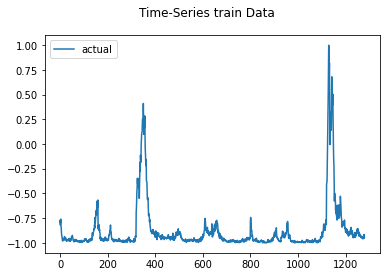

2023-03-05 17:58:22.802647: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-05 17:58:22.802692: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-05 17:58:22.802717: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-05 17:58:22.802961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-05 17:58:26.364073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_input (InputLayer)          [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_2_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            11564971    gru_input[0][0]                  
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1)            5420971     gru_2_input[0][0]                
__________

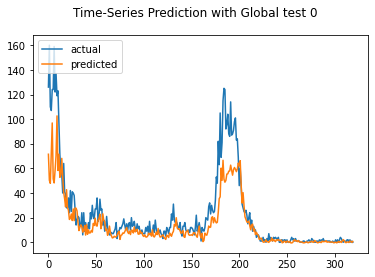

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_4_input (InputLayer)        [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_6_input (InputLayer)        [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1)            11564971    gru_4_input[0][0]                
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1)            5420971     gru_6_input[0][0]                
____________________________________________________________________________________________

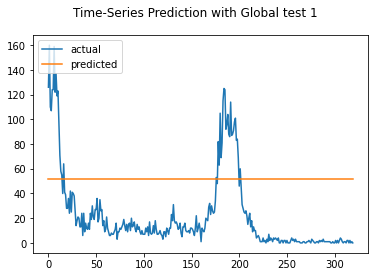

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_8_input (InputLayer)        [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_10_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1)            11564971    gru_8_input[0][0]                
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1)            5420971     gru_10_input[0][0]               
________

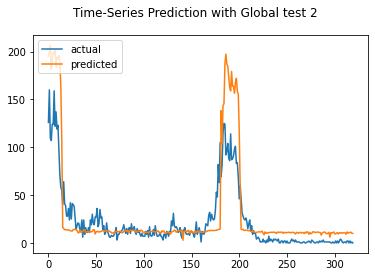

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_12_input (InputLayer)       [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_14_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1)            11564971    gru_12_input[0][0]               
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1)            5420971     gru_14_input[0][0]               
________

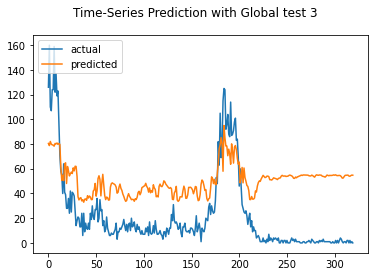

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_16_input (InputLayer)       [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_18_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 1)            11564971    gru_16_input[0][0]               
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 1)            5420971     gru_18_input[0][0]               
____________________________________________________________________________________________

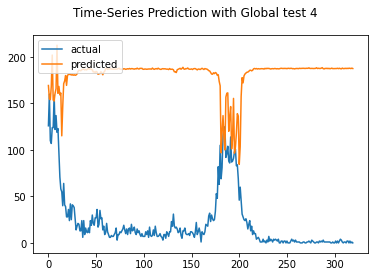

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_20_input (InputLayer)       [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_22_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 1)            11564971    gru_20_input[0][0]               
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 1)            5420971     gru_22_input[0][0]               
________

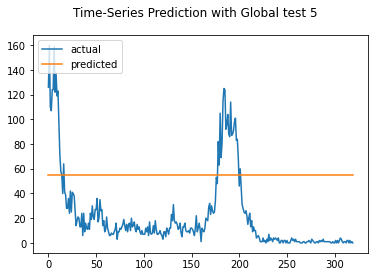

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_24_input (InputLayer)       [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_26_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 1)            11564971    gru_24_input[0][0]               
__________________________________________________________________________________________________
sequential_13 (Sequential)      (None, 1)            5420971     gru_26_input[0][0]               
________

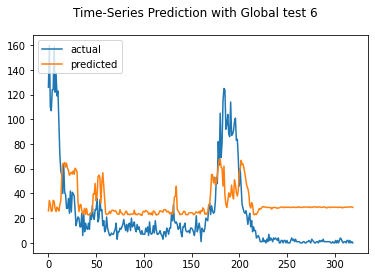

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gru_28_input (InputLayer)       [(None, 3, 2049)]    0                                            
__________________________________________________________________________________________________
gru_30_input (InputLayer)       [(None, 3, 1)]       0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 1)            11564971    gru_28_input[0][0]               
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 1)            5420971     gru_30_input[0][0]               
____________________________________________________________________________________________

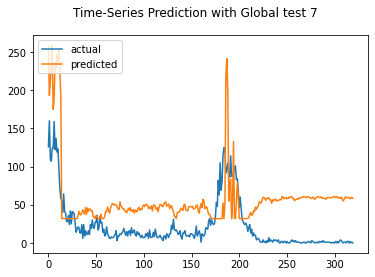

In [ ]:
# Use the Function:
sequence=train_X.shape[1]
features=train_X.shape[2]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global', fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test)


In [ ]:
scalers['scaler_Labels'].inverse_transform(test_y).mean()

scalers['scaler_Labels'].inverse_transform(train_y).mean()